<a href="https://colab.research.google.com/github/sangse/Stock-AI/blob/main/%EC%8B%A0%EA%B7%9C%EC%83%81%EC%9E%A5%EC%A3%BC_%EC%A3%BC%EA%B0%80_%EC%98%88%EC%B8%A1_Transformer_Encoder_Block_Classification_(with_kmeans_block).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Train Data Extraction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler



def df_slicing_window_2(df, window_size, shift_size):
  total_length = len(df)
  # 항상 마지막 부분까지 포함하기 위해 올림을 사용
  numofblock = math.ceil((total_length - window_size) / shift_size) + 1
  # 데이터 블럭들을 저장하는 리스트
  data_list = []
  target_list = []
  for num in range(numofblock):
      start_index = num * shift_size
      end_index = start_index + window_size
      # 인덱스 범위가 데이터 길이를 초과하지 않도록 처리

      if end_index+12 > total_length:
          break

      data_list.append(df.iloc[start_index:end_index])
      target_list.append(df.iloc[end_index:end_index+12])
  return data_list,target_list



def data_X_y_extraction():
  # 디렉토리 경로
  directory = '/content/drive/MyDrive/data/신규상장데이터'

  # 해당 디렉토리 안의 파일 이름들을 리스트로 가져옴
  file_names = os.listdir(directory)

  min_max_scaler = MinMaxScaler()

  train_data = []
  target_data = []


  for name in file_names:
    # 파일 데이터프레임으로 저장하고 일자를 인덱스를 정립하고 오름차순으로 정렬. 상장후 81일치 데이터만 사용.
    tmp = pd.read_csv(os.path.join(directory, name),encoding='cp949').head(81)
    tmp['일자'] = pd.to_datetime(tmp['일자'],format='%Y%m%d')
    tmp = tmp.sort_values(by='일자',ascending=True)
    tmp.set_index('일자',inplace=True)

    # 공모가 대비 현재가 특징 추가
    tmp['공모대비현재가비율'] = tmp['현재가']/tmp['공모가']

    # Minmax scaler
    tmp['현재가'] = min_max_scaler.fit_transform(tmp[['현재가']])
    tmp['저가'] = min_max_scaler.fit_transform(tmp[['저가']])
    tmp['고가'] = min_max_scaler.fit_transform(tmp[['고가']])
    tmp['시가'] = min_max_scaler.fit_transform(tmp[['시가']])
    tmp['거래량'] = min_max_scaler.fit_transform(tmp[['거래량']])
    tmp['거래대금'] = min_max_scaler.fit_transform(tmp[['거래대금']])

    # 필요없는 특징들은 제거
    drop_list = ['대업종구분',	'소업종구분',	'종목정보' ,'종목코드','Unnamed: 0','종목명','시장구분','공모가','상장등락률']
    tmp.drop(drop_list,axis=1,inplace=True)



    # NaN 값이 하나라도 있으면 건너뛰기
    if tmp.isna().any().any():
        continue
    # 데이터를 window size 12 , shift_size 4로 잘라준다.
    x,y = df_slicing_window_2(tmp,24,4)
    train_data += x
    target_data += y


  return train_data,target_data
tmp_x,tmp_y = data_X_y_extraction()

In [ ]:
# tensor 형태로 변환하고, encoder넣어서 clustering 변수 추가.
tmp_x_tensor = torch.tensor(np.array(tmp_x),dtype=torch.float32).unsqueeze(1)
tmp_x_labels = kmeans.predict(encoder(tmp_x_tensor).detach().numpy())
tmp_x_labels = torch.tensor(tmp_x_labels,dtype=torch.float32)
tmp_x_labels = tmp_x_labels.unsqueeze(1).repeat_interleave(24,dim=1).unsqueeze(2)
tmp_x_tensor = torch.cat([tmp_x_tensor.squeeze(),tmp_x_labels],dim=2)

tmp_y_tensor = torch.tensor(np.array(tmp_y),dtype=torch.float32).unsqueeze(1)
tmp_y_labels = kmeans.predict(encoder(tmp_y_tensor).detach().numpy())
tmp_y_labels = torch.tensor(tmp_y_labels,dtype=torch.float32)
tmp_y_labels = tmp_y_labels.unsqueeze(1).repeat_interleave(24,dim=1).unsqueeze(2)
tmp_y_tensor = torch.cat([tmp_y_tensor.squeeze(),tmp_y_labels],dim=2)[:,:12,:]

### Data load of Training Set


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

X = torch.load('/content/drive/MyDrive/data/tmp_x_tensor.pt')
y = torch.load('/content/drive/MyDrive/data/tmp_y_tensor.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y_label = y[:,0,-1].type(torch.LongTensor)
y_label.to(device)
X.to(device)
y.to(device)

### Transformer Classification Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=24):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, num_classes):
        super(TimeSeriesTransformer, self).__init__()
        self.linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.linear(x)  # Project input data to d_model dimensions
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:,:,0]
        output = self.decoder(x)
        return output


In [ ]:
# Hyperparameters
input_dim = 8  # Number of features
seq_length = 24  # Sequence length
d_model = 128  # Dimension of the model
nhead = 4  # Number of attention heads
num_layers = 2  # Number of Transformer layers
num_classes = 10  # Number of output classes

# Initialize the model
model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train,y_train = X[:int(0.8*len(X))],y_label[:int(0.8*len(y))]
X_val,y_val = X[int(0.8*len(X)):],y_label[int(0.8*len(y)):]


# Data Loader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

AssertionError: Size mismatch between tensors

In [ ]:
num_epochs = 100  # 학습 에폭 수
num_samples = len(train_loader.dataset)  # 전체 훈련 데이터 수
num_val_samples = len(val_loader.dataset)  # 전체 검증 데이터 수

best_val_loss = float('inf')  # 가장 좋은 검증 손실을 저장하기 위한 변수 초기화

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0

    # 훈련 루프
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(inputs)  # 모델을 통한 순전파
        loss = criterion(outputs, targets)  # 손실 계산
        loss.backward()  # 역전파 실행
        optimizer.step()  # 매개변수 업데이트

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / num_samples

    # 검증 루프
    model.eval()  # 모델을 평가 모드로 설정
    running_val_loss = 0.0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)

    val_loss = running_val_loss / num_val_samples
    print(f'Epoch {epoch+1}  - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

    # 검증 손실이 현재까지의 최소값보다 낮을 경우, 모델 상태 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model.pth')
        print(f'New best model saved at epoch {epoch+1} with validation loss {val_loss:.4f}')


### Transformer Stock Prediction

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import math


In [ ]:
X = torch.load('/content/drive/MyDrive/data/tmp_x_tensor.pt')
y = torch.load('/content/drive/MyDrive/data/tmp_y_tensor.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X.to(device)
y.to(device)

In [4]:
X.shape, y.shape

(torch.Size([3153, 24, 8]), torch.Size([3153, 12, 8]))

In [23]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=24):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1),:]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, future_seq=12):
        super(TimeSeriesTransformer, self).__init__()
        self.linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(transformer_encoder_layer, num_layers=num_layers)

        self.future_seq = future_seq
        self.decoder = nn.Linear(d_model, 8)  # 예측할 시퀀스의 각 값에 대한 출력
        self.transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, num_layers=num_layers)
        self.linear_decoder = nn.Linear(input_dim, d_model)
    def forward(self, x, y, mode = 'train'):

        x = self.linear(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)

        memory = self.transformer_encoder(x)

        if mode == 'train':
            y = self.linear_decoder(y)
            y = self.pos_encoder(y)
            y = y.permute(1, 0, 2)
            output = self.transformer_decoder(y, memory)
            output = output.permute(1, 0, 2)
            output = self.decoder(output)
            return output
        else:
            target = torch.zeros(x.size(1), self.future_seq, x.size(2), device=x.device)
            target = self.pos_encoder(target)
            target = target.permute(1, 0, 2)
            output = self.transformer_decoder(target, memory)
            output = output.permute(1, 0, 2)
            output = self.decoder(output)
            return output


In [24]:
# Hyperparameters
input_dim = 8  # Number of features
seq_length = 24  # Sequence length
d_model = 128  # Dimension of the model
nhead = 4  # Number of attention heads
num_layers = 1  # Number of Transformer layers
future_seq = 12  # Number of output classes

# Initialize the model
model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, future_seq).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train,y_train = X[:int(0.8*len(X))],y[:int(0.8*len(y))]
X_val,y_val = X[int(0.8*len(X)):],y[int(0.8*len(y)):]

# Data Loader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [25]:
num_epochs = 100  # 학습 에폭 수
num_samples = len(train_loader.dataset)  # 전체 훈련 데이터 수
num_val_samples = len(val_loader.dataset)  # 전체 검증 데이터 수

best_val_loss = float('inf')  # 가장 좋은 검증 손실을 저장하기 위한 변수 초기화

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0

    # 훈련 루프
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(inputs,targets,mode='train')  # 모델을 통한 순전파
        loss = criterion(outputs, targets)  # 손실 계산
        loss.backward()  # 역전파 실행
        optimizer.step()  # 매개변수 업데이트

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / num_samples

    # 검증 루프
    model.eval()  # 모델을 평가 모드로 설정
    running_val_loss = 0.0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, targets in val_loader:
            outputs = model(inputs,targets)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)

    val_loss = running_val_loss / num_val_samples
    print(f'Epoch {epoch+1}  - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

    # 검증 손실이 현재까지의 최소값보다 낮을 경우, 모델 상태 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model.pth')
        print(f'New best model saved at epoch {epoch+1} with validation loss {val_loss:.4f}')


Epoch 1  - Training Loss: 0.9190 - Validation Loss: 0.0911
New best model saved at epoch 1 with validation loss 0.0911
Epoch 2  - Training Loss: 0.3324 - Validation Loss: 0.0190
New best model saved at epoch 2 with validation loss 0.0190
Epoch 3  - Training Loss: 0.2623 - Validation Loss: 0.0104
New best model saved at epoch 3 with validation loss 0.0104
Epoch 4  - Training Loss: 0.2216 - Validation Loss: 0.0072
New best model saved at epoch 4 with validation loss 0.0072
Epoch 5  - Training Loss: 0.1849 - Validation Loss: 0.0050
New best model saved at epoch 5 with validation loss 0.0050
Epoch 6  - Training Loss: 0.1529 - Validation Loss: 0.0060
Epoch 7  - Training Loss: 0.1328 - Validation Loss: 0.0071
Epoch 8  - Training Loss: 0.1101 - Validation Loss: 0.0047
New best model saved at epoch 8 with validation loss 0.0047
Epoch 9  - Training Loss: 0.0821 - Validation Loss: 0.0058
Epoch 10  - Training Loss: 0.0725 - Validation Loss: 0.0124
Epoch 11  - Training Loss: 0.0511 - Validation Lo

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


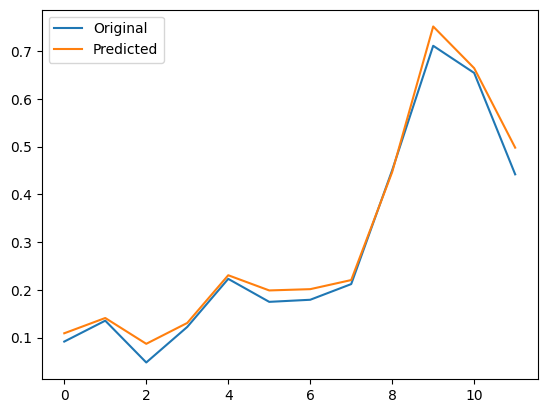

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


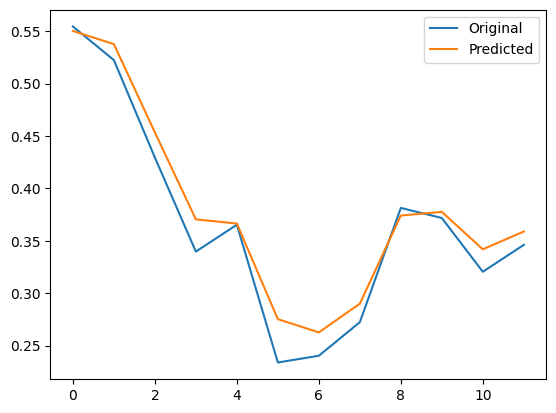

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


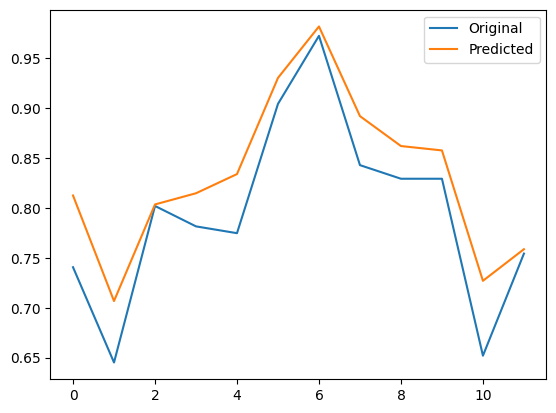

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


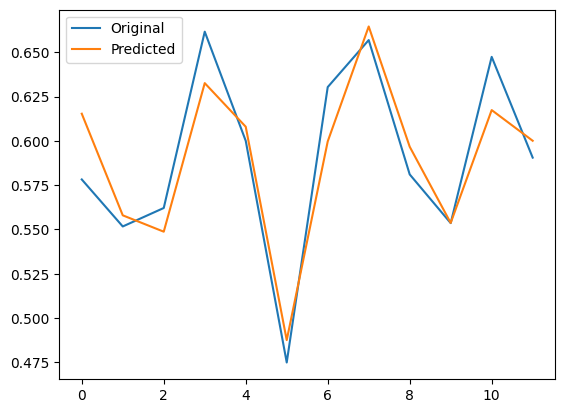

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


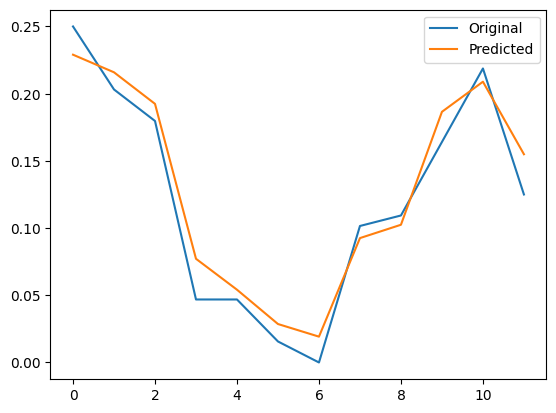

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


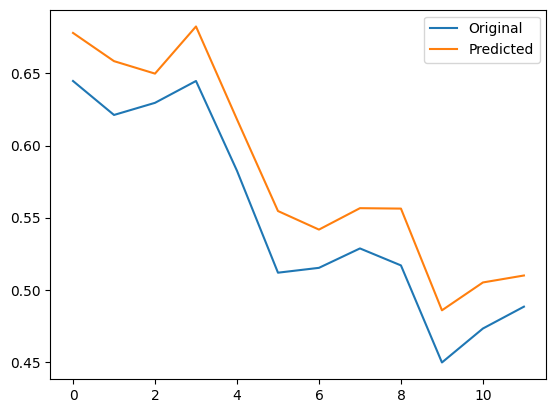

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


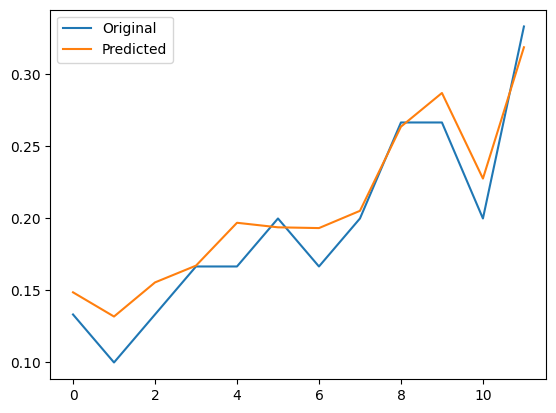

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


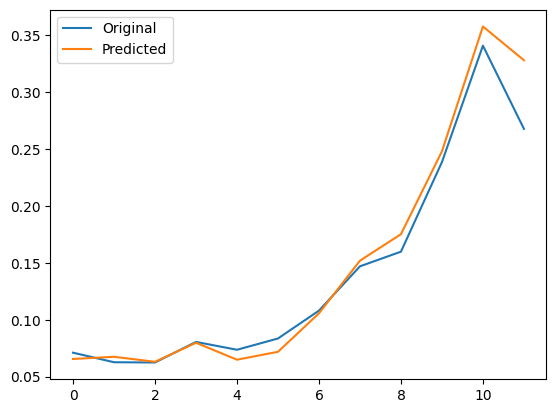

torch.Size([64, 12, 8])
torch.Size([64, 12, 8])


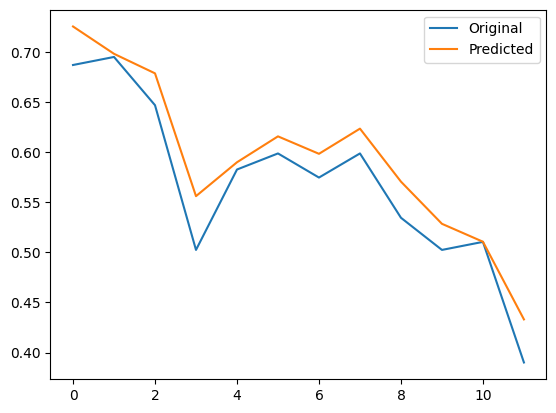

torch.Size([55, 12, 8])
torch.Size([55, 12, 8])


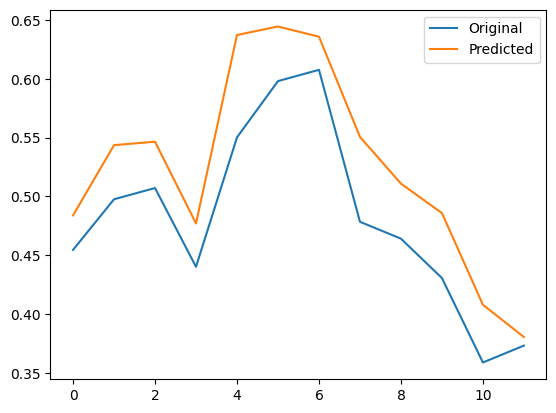

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs,targets)
        print(outputs.shape)
        print(targets.shape)

        ori = targets[1,:,0]
        pred = outputs[1,:,0]

        sns.lineplot(ori, label='Original')
        sns.lineplot(pred, label='Predicted')
        plt.legend()
        plt.show()